## Notebook for creating Simulation 3

See Section 6.3 of Susobhanan+ 2024.

In [26]:
from pint.models import get_model, get_model_and_toas
from pint.simulation import make_fake_toas_fromtim
from pint.logging import setup as setup_log
from pint.utils import dmwavex_setup, pldmnoise_from_dmwavex
from pint.fitter import WLSFitter

from io import StringIO
import numpy as np
import astropy.units as u
from copy import deepcopy
from matplotlib import pyplot as plt
import corner
from joblib import Parallel, delayed

In [2]:
setup_log(level="WARNING")

1

In [35]:
par_sim = """
    PSR           SIM3
    RAJ           05:00:00     1
    DECJ          15:00:00     1
    PEPOCH        55000
    F0            100          1
    F1            -1e-15       1 
    PHOFF         0            1
    DM            15           1
    TNDMAMP                             -13.5
    TNDMGAM                               4.0
    TNDMC        30
    TZRMJD        55000
    TZRFRQ        1400 
    TZRSITE       gbt
    UNITS         TDB
    EPHEM         DE440
    CLOCK         TT(BIPM2019)
"""

In [36]:
m0 = get_model(StringIO(par_sim))

In [37]:
nharm_opt = 17

In [38]:
m1, t = get_model_and_toas("sim4.wx1.par", "sim4.tim")

In [8]:
Tspan = t.get_mjds().max() - t.get_mjds().min()

idxs = m1.components["DMWaveX"].get_indices()
for idx in reversed(idxs):
    if idx > nharm_opt:
        m1.components["DMWaveX"].remove_dmwavex_component(idx)

ftr = WLSFitter(t, m1)
ftr.fit_toas(maxiter=5)

1991.2371077679044953

In [9]:
print(ftr.model)

# Created: 2024-05-31T15:20:42.931681
# PINT_version: 1.0+232.g3fe7a43e
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-35-generic-x86_64-with-glibc2.35
# Python: 3.9.19 (main, May  6 2024, 19:43:03) 
# [GCC 11.2.0]
# Format: pint
PSR                                  SIM2
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999566727662
FINISH             56985.0000000463521528
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   1991.2371077679045
CHI2R                  1.0159372998815839
TRES               0.99602437359789639106
RAJ                      4:59:59.99999565 1 0.00000186978918702429
DECJ                    15:00:00.00015102 1 0.00015994924348661457
PMRA                                  0.0
PMDEC                  

In [17]:
def simulate_and_measure():
    setup_log(level="WARNING")
    
    t = make_fake_toas_fromtim(
        "sim4.tim",
        m0,
        add_noise=True,
        add_correlated_noise=True,
        name="fake",
    )

    try:
        ftr = WLSFitter(t, m1)
        ftr.fit_toas(maxiter=6)
    
        m_pint_1 = pldmnoise_from_dmwavex(ftr.model)
    
        print(
            m_pint_1.TNREDAMP.value,
            m_pint_1.TNREDAMP.uncertainty_value,
            m_pint_1.TNREDGAM.value,
            m_pint_1.TNREDGAM.uncertainty_value
        )
        
        return (
            m_pint_1.TNDMAMP.value,
            m_pint_1.TNDMAMP.uncertainty_value,
            m_pint_1.TNDMGAM.value,
            m_pint_1.TNDMGAM.uncertainty_value
        )
    except Exception as e:
        print("Error")
        return np.nan, np.nan, np.nan, np.nan

In [18]:
results = Parallel(n_jobs=16)(
    delayed(simulate_and_measure)() for _ in range(1000)
)

/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required f

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


KeyboardInterrupt: 

In [19]:
results = np.genfromtxt("results.txt")

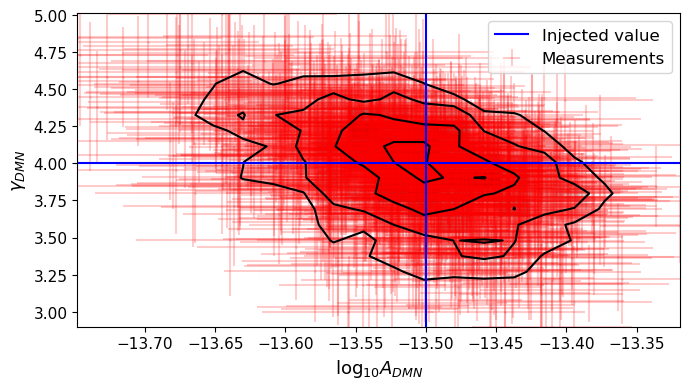

In [46]:
plt.figure(figsize=(7, 4))
plt.errorbar(x=results[:,0], xerr=results[:,1], y=results[:,2], yerr=results[:,3], color="red", alpha=0.2, ls="", label="Measurements")
corner.hist2d(results[:,0], results[:,2], smooth=0.5)
plt.xlabel("$\\log_{10} A_{DMN}$", fontsize=13)
plt.ylabel("$\\gamma_{DMN}$", fontsize=13)
plt.axhline(m0.TNDMGAM.value, label="Injected value", color="blue")
plt.axvline(m0.TNDMAMP.value, color="blue")
plt.tick_params(axis="both", labelsize=11)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("sim4-multisim.pdf")

In [25]:
m1 = deepcopy(m)
m1.remove_component("PLRedNoise")

Tspan = t.get_mjds().max() - t.get_mjds().min()
wavex_setup(m1, Tspan, n_freqs=45)

# Lines commented out to avoid accidentally rewriting the files.
# m1.write_parfile("simulations/sim3.wx.par")